# Problem Set 1

In [12]:
import jax
import jax.numpy as np
import jax.lax as lax

In [13]:
import tools.assign as ps

In [14]:
# configure matplotlib output
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [15]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [16]:
# model parameters
par = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
}

## Grid

In [17]:
vfi_grid = ps.Valfunc(par)

In [18]:
vp_grid, kp_grid, hist_grid = vfi_grid.fast_solve()

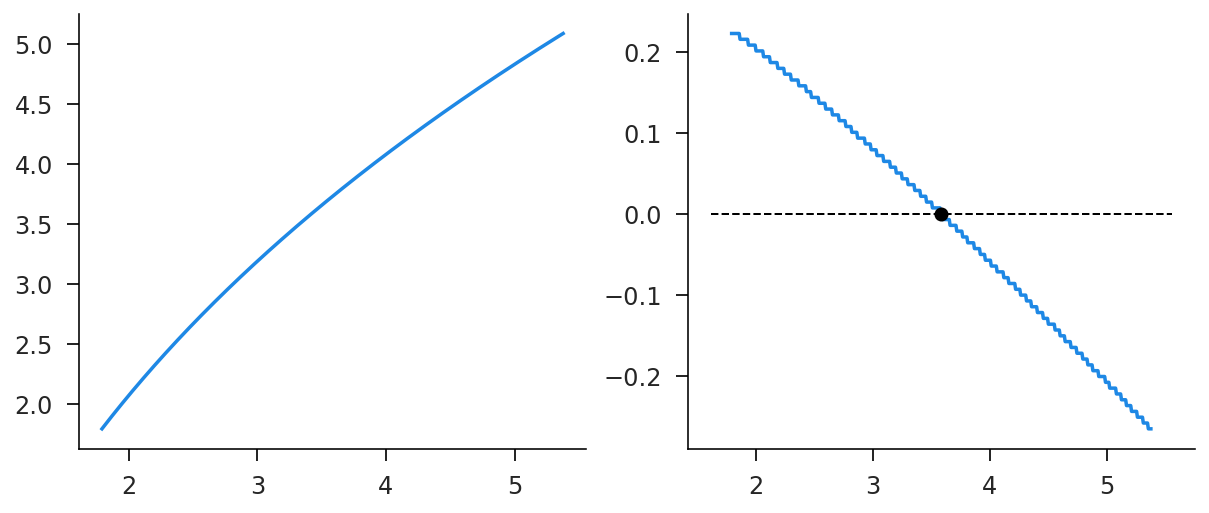

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(vfi_grid.k_grid, vp_grid);
ax[1].plot(vfi_grid.k_grid, kp_grid-vfi_grid.k_grid);
ax[1].scatter(vfi_grid.kss, 0, c='k', zorder=10);
ax[1].hlines(0, *ax[1].get_xlim(), color='k', linestyle='--', linewidth=1);

## Interp

In [20]:
vfi_int = ps.Valfunc(par, interp=True)

In [21]:
vp_int, kp_int, hist_int = vfi_int.fast_solve(K=1000)

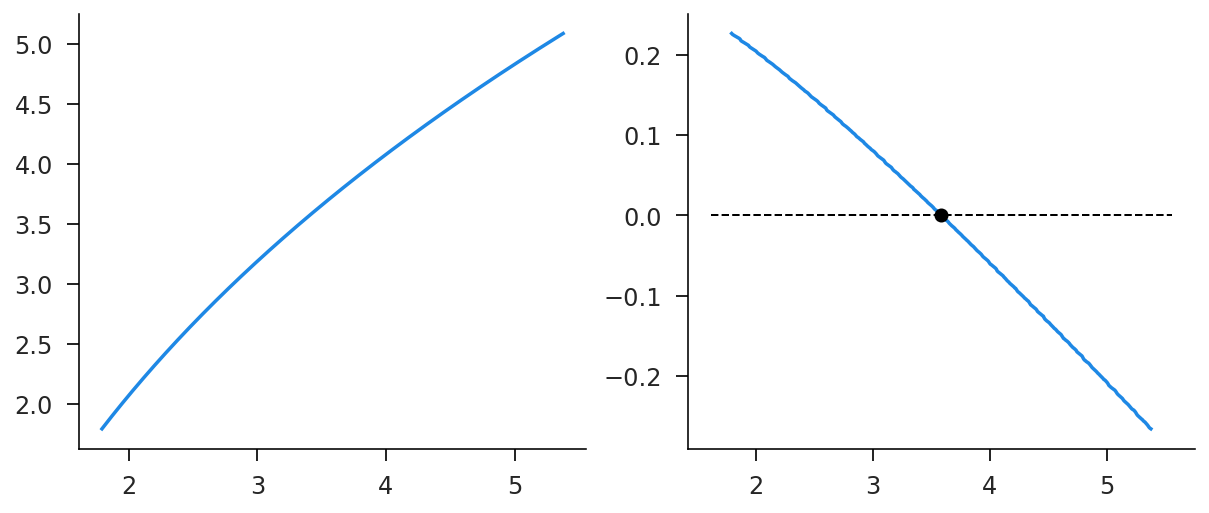

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(vfi_int.k_grid, vp_int);
ax[1].plot(vfi_int.k_grid, kp_int-vfi_int.k_grid);
ax[1].scatter(vfi_int.kss, 0, c='k', zorder=10);
ax[1].hlines(0, *ax[1].get_xlim(), color='k', linestyle='--', linewidth=1);